Домашнее задание № 9

Используя датасет из https://github.com/Phylliida/Dialogue-Datasets
Используя материалы лекции (ноутбук ) обучить модель seq2seq с механизмом внимания для получения ответов на вопросы.
Взять 1000 сценариев.

In [1]:
import time
import torch
import zipfile
import collections
from torch import nn
import math
import pandas as pd
import numpy as np

Использовал датасет яндекс толоки https://toloka.yandex.ru/datasets/



In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#data = pd.read_csv('./drive/My Drive/dialogues.tsv', sep='\t')
data = pd.read_csv('dialogues.tsv', sep='\t')

In [3]:
import re

In [4]:
for i in data['dialogue'].head():
    print(re.split(r'Пользователь \d:', re.sub('<..*?>', ' ' , i)))

[' ', ' Привет) расскажи о себе   ', ' Привет) под вкусный кофеек настроение поболтать появилось )   ', ' Что читаешь? Мне нравится классика   ', ' Я тоже люблю пообщаться   ', ' Люблю животных, просто обожаю, как и свою работу)   ', ' Я фантастику люблю   ', ' А я выращиваю фиалки   ', ' И веду здоровый и активный образ жизни!   ', ' Ух ты, интересно.   ', ' Ты случайно не принц на белом коне? Я его очень жду ..   ', ' А у меня из хобби каждую неделю тусить с моим лучшим другом)  ']
[' ', ' Привет!   ', ' Привет,Как жизнь?   ', ' Отлично) Солнышко светит, птички поют!   ', ' Я вот сегодня понял, что меня тупо используют, всем нужны от меня лишь деньги, ненавижу людей   ', ' Чем занимаешься по жизни, я вот бизнесмен.   ', ' А я вот учу детей, работаю с начальными классами   ', ' Не все люди такие, как ты говоришь   ', ' Помимо работы чем еще ты занимаешься?   ', ' К свадьбе готовлюсь   ', ' А ты?   ', ' Вот видишь) значит, нашел такую женщину, которой не нужны от тебя деньги   ', ' Да 

In [5]:
data['dialogue_list']= data['dialogue'].apply(lambda x: re.split(r'Пользователь ', re.sub('\s\s+',' ',re.sub('<..*?>', ' ' , x))))

In [6]:
for i in data['dialogue_list'].head():
    print(i)

[' ', '2: Привет) расскажи о себе ', '1: Привет) под вкусный кофеек настроение поболтать появилось ) ', '2: Что читаешь? Мне нравится классика ', '2: Я тоже люблю пообщаться ', '1: Люблю животных, просто обожаю, как и свою работу) ', '1: Я фантастику люблю ', '2: А я выращиваю фиалки ', '2: И веду здоровый и активный образ жизни! ', '1: Ух ты, интересно. ', '2: Ты случайно не принц на белом коне? Я его очень жду .. ', '1: А у меня из хобби каждую неделю тусить с моим лучшим другом) ']
[' ', '1: Привет! ', '2: Привет,Как жизнь? ', '1: Отлично) Солнышко светит, птички поют! ', '2: Я вот сегодня понял, что меня тупо используют, всем нужны от меня лишь деньги, ненавижу людей ', '2: Чем занимаешься по жизни, я вот бизнесмен. ', '1: А я вот учу детей, работаю с начальными классами ', '1: Не все люди такие, как ты говоришь ', '1: Помимо работы чем еще ты занимаешься? ', '2: К свадьбе готовлюсь ', '2: А ты? ', '1: Вот видишь) значит, нашел такую женщину, которой не нужны от тебя деньги ', '2: 

In [7]:
data['dialogue_list'] = data['dialogue_list'].apply(lambda x: list(filter(lambda s: s.strip() != '', x)))

In [8]:
data['dialogue_list'][1]

['1: Привет! ',
 '2: Привет,Как жизнь? ',
 '1: Отлично) Солнышко светит, птички поют! ',
 '2: Я вот сегодня понял, что меня тупо используют, всем нужны от меня лишь деньги, ненавижу людей ',
 '2: Чем занимаешься по жизни, я вот бизнесмен. ',
 '1: А я вот учу детей, работаю с начальными классами ',
 '1: Не все люди такие, как ты говоришь ',
 '1: Помимо работы чем еще ты занимаешься? ',
 '2: К свадьбе готовлюсь ',
 '2: А ты? ',
 '1: Вот видишь) значит, нашел такую женщину, которой не нужны от тебя деньги ',
 '2: Да я надеюсь на это,люблю ее ']

In [9]:
def add_seq_pers(x):
    cur_pers = ''
    new_list = []
    cur_str = ''
    for i in x:
        if i[:2] != cur_pers:
          #                              смайлики                       двойные пробелы .       убирает два знака типа ? .              ставит пробел между словом и знаком
            new_list.append(re.sub(r'\d+','',re.sub(r'[\?\!\:\)\(\-]{2,5}','',re.sub(r'\s\s+',' ', re.sub(r'([\!\.?,\)\(\:\-)])\s*([\!\.?,\)\(\:\-)])+','.',re.sub(r'([\!\.?,\)\(\:\-)]+)', r' \1',re.sub(r'[\)\()]','.', cur_str.lower()).strip()))))))
            cur_str = i[2:]
            cur_pers = i[:2]    
        else: 
            cur_str += ' . ' +  i[2:] 
    return new_list[1:]   

In [10]:
data['dialogue_list'] = data['dialogue_list'].apply(add_seq_pers)

In [11]:
for i in data['dialogue_list'].head(10):
    print(i)

['привет . расскажи о себе', 'привет . под вкусный кофеек настроение поболтать появилось .', 'что читаешь ? мне нравится классика . я тоже люблю пообщаться', 'люблю животных , просто обожаю , как и свою работу . я фантастику люблю', 'а я выращиваю фиалки . и веду здоровый и активный образ жизни !', 'ух ты , интересно .', 'ты случайно не принц на белом коне ? я его очень жду .']
['привет !', 'привет ,как жизнь ?', 'отлично . солнышко светит , птички поют !', 'я вот сегодня понял , что меня тупо используют , всем нужны от меня лишь деньги , ненавижу людей . чем занимаешься по жизни , я вот бизнесмен .', 'а я вот учу детей , работаю с начальными классами . не все люди такие , как ты говоришь . помимо работы чем еще ты занимаешься ?', 'к свадьбе готовлюсь . а ты ?', 'вот видишь . значит , нашел такую женщину , которой не нужны от тебя деньги']
['привет . как дела ?', 'добрый день . хорошо , чем увлекаетесь ?', 'я бегаю по утрам а ты . есть любимые вещи или еда . занят ?', 'я люблю петь в к

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


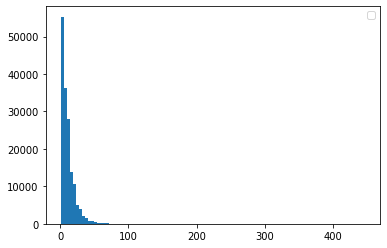

In [13]:
plt.hist([len(l.split(' ')) for l in sum(data['dialogue_list'].tolist(),[])], bins=100)
plt.legend(loc='upper right')
plt.show()

No handles with labels found to put in legend.


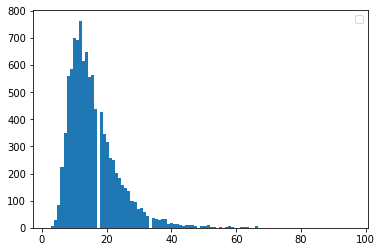

In [14]:
plt.hist([len(l) for l in data['dialogue_list'].tolist()], bins=100)
plt.legend(loc='upper right')
plt.show()

In [15]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            uniq_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk, uniq_tokens = 0, ['<unk>']
        uniq_tokens +=  [token for token, freq in self.token_freqs 
                         if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [16]:
source = [[s.split(' ') for s in l] for l in data['dialogue_list'].tolist()]


In [17]:
len(source)

10013

In [0]:
tmp_sourse = sum(source, [])

In [0]:
tmp2_sourse = sum(tmp_sourse, [])

In [0]:
len(set(tmp2_sourse))

62563

In [19]:
import pickle

In [0]:
with open('./drive/My Drive/data_for_hw_9.pkl', 'wb') as f:
    pickle.dump(tmp2_sourse, f)

In [20]:
#with open('./drive/My Drive/data_for_hw_9.pkl', 'rb') as f:
with open('data_for_hw_9.pkl', 'rb') as f:
    tmp2_sourse = pickle.load(f)

In [21]:
def build_vocab(tokens):
    #tokens = [token for line in tokens for token in line]
    return Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(tmp2_sourse)
len(src_vocab)

19439

In [22]:
src_vocab[source[0]]

[[18, 4, 148, 38, 68],
 [18, 4, 287, 1384, 11989, 236, 737, 3817, 4],
 [23, 1439, 7, 31, 85, 2476, 4, 6, 29, 14, 189],
 [14, 79, 5, 93, 74, 5, 17, 11, 145, 151, 4, 6, 1260, 14],
 [8, 6, 1197, 3512, 4, 11, 802, 861, 11, 653, 655, 119, 22],
 [318, 13, 5, 152, 4],
 [13, 1073, 12, 7681, 15, 6406, 6519, 7, 6, 136, 21, 448, 4]]

In [23]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0][0]], 50, src_vocab.pad)

[18,
 4,
 148,
 38,
 68,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [24]:
def pad_line(lines, max_len_line, padding_token):
    if len(lines) > max_len_line:
        return lines[:max_len_line]
    return lines + [padding_token] * (max_len_line - len(lines))

In [25]:
def build_array(lines, vocab, max_len, max_len_line):
    lines = [vocab[line] for line in lines]
    lines = [[pad([vocab.bos] + l + [vocab.eos],max_len,vocab.pad) for l in line] for line in lines]
    lines = [pad_line(line,max_len_line,[vocab.pad]*max_len) for line in lines]
    array = torch.LongTensor(lines)
    valid_len = (array != vocab.pad).sum(axis=2)
    mask = torch.zeros_like(array).type(torch.float)
    mask = (array != vocab.pad).type(torch.float)
    #for i in range(len(valid_len)):
    #    mask[i, :valid_len[i]]=1.
    return array, valid_len, mask

In [26]:
def load_data_nmt(batch_size, max_len, max_len_lines): 
    src_vocab = build_vocab(tmp2_sourse)
    src_array, src_valid_len, src_trg = build_array(source[:1000], src_vocab, max_len, max_len_lines)
    train_data = torch.utils.data.TensorDataset(src_array, src_valid_len, src_trg)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, train_iter

In [27]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.set_state = None

    def forward(self, X, is_set_state, *args):
        X = self.embedding(X) 
        X = X.permute(1, 0, 2)
        if is_set_state and (self.set_state is not None): 
            
            state = (self.set_state[0].detach(),self.set_state[1].detach())
        else:
            
            state = (torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)), torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)))
        out, self.set_state = self.rnn(X, state)
        
        return out, self.set_state

In [28]:
class MLPAttention(nn.Module):  
    def __init__(self, inputs, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(inputs, units, bias=False)
        self.W_q = nn.Linear(inputs, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        query, key = torch.tanh(self.W_k(query)), torch.tanh(self.W_q(key))
        # expand query to (batch_size, #querys, 1, units), and key to 
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.  
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(dim=-1)
        attention_weights = self.dropout(scores.softmax(dim=-1))
        return torch.bmm(attention_weights, value)

In [29]:
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.attention_cell = MLPAttention(num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.num_hiddens = num_hiddens
        self.embed_size = embed_size
        self.vocab_size = vocab_size

    def init_state(self, enc_outputs, *args):
        return (enc_outputs[0].permute(1,0,2), enc_outputs[1])

    def forward(self, X, state):
        enc_outputs, hidden_state = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs = []
        for x in X:
            # query shape: (batch_size, 1, hidden_size)
            query = hidden_state[0][-1].unsqueeze(1)
            # context has same shape as query
            context = self.attention_cell(query, enc_outputs, enc_outputs)
            # concatenate on the feature dimension
            x = torch.cat([context, x.unsqueeze(1)], dim=-1)
            # reshape x to (1, batch_size, embed_size+hidden_size)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state]
            
            
       # out, state = self.rnn(X, state)
       # out = self.dense(out.view(-1, self.num_hiddens)).view(out.shape[0], out.shape[1], self.vocab_size).permute(1, 0, 2)
       # return out, state

In [32]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, is_set_state, *args):
        enc_outputs = self.encoder(enc_X, is_set_state, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [54]:
def train(model, data_iter, lr, num_epochs, out_vocab_size,trainer=None):
    if trainer is None:
        trainer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum , num_batch= 0.0, 0.0, 0
        print(f'batch ', end=' ')
        for batch in data_iter:
            print(f' {num_batch} ', end=' ')
            #is_set_state = False
            X, X_vlen, mask = [x for x in batch]
            #X, X_vlen, Y, Y_vlen, mask = [x for x in batch]
            use_state = False
            for i in range(X.shape[1]-1):
                trainer.zero_grad()
                #Y_input, Y_label, Y_vlen, mask = Y[:,:-1], Y[:,1:], Y_vlen-1, mask[:,1:]
                #print(X.shape, X_vlen.shape, mask.shape)     
                cur_X, cur_X_vlen, cur_Y, cur_Y_vlen, cur_mask = X[:,i,:], X_vlen[:,i], X[:,i+1,:], X_vlen[:,i+1], mask[:,i+1,:]  
                
                cur_Y_input, cur_Y_label, cur_Y_vlen, cur_mask = cur_Y[:,:-1], cur_Y[:,1:], cur_Y_vlen-1, cur_mask[:,1:]
                
                cur_Y_hat, _ = model(cur_X, cur_Y_input, use_state, cur_X_vlen, cur_Y_vlen )
            
                l = (loss(cur_Y_hat.reshape(-1,out_vocab_size), cur_Y_label.reshape(-1)) * cur_mask.reshape(-1)).sum() 
            
                l.backward()
                num_tokens = cur_Y_vlen.sum().item()
                trainer.step()
                l_sum += l.item()
                num_tokens_sum += num_tokens
                use_state = True
            num_batch+=1 
        print("epoch %d, loss %.3f, time %.1f sec" % (
            epoch, l_sum/num_tokens_sum, time.time()-tic))
        tic = time.time()

In [34]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len, max_len_lines = 100, 50, 40
lr, num_epochs = 0.01, 75

src_vocab, train_iter = load_data_nmt(batch_size=100, max_len=50, max_len_lines = 40)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = AttentionDecoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 1, loss 7.438, time 217.6 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 2, loss 6.949, time 217.0 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 3, loss 6.439, time 215.9 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 4, loss 6.095, time 216.2 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 5, loss 5.894, time 215.4 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 6, loss 5.741, time 216.8 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 7, loss 5.613, time 218.4 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
epoch 8, loss 5.496, time 215.9 sec
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8


KeyboardInterrupt: 

In [35]:
def translate(model, src_sentence, src_vocab, tgt_vocab, max_len):
    res = []
    use_state = False
    for sen in  src_sentence:
        src_tokens = src_vocab[sen.lower().split(' ')]
        src_len = len(src_tokens)
        if src_len < max_len:
            src_tokens += [src_vocab.pad] * (max_len - src_len)
        enc_X = torch.LongTensor(src_tokens)
        enc_valid_length = torch.LongTensor([src_len])
                    
        enc_outputs = model.encoder(enc_X.unsqueeze(axis=0),use_state, enc_valid_length )
        use_state = True
        dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
        dec_X = torch.LongTensor([tgt_vocab.bos]).unsqueeze(axis=0)
        predict_tokens = []
        for _ in range(max_len):
            Y, dec_state = model.decoder(dec_X, dec_state)
            dec_X = Y.argmax(axis=2)
            py = dec_X.squeeze(axis=0).type(torch.long).item()
            if py == tgt_vocab.eos:
                break
            predict_tokens.append(py)
        res.append(f"{sen} =>{' '.join(tgt_vocab.to_tokens(predict_tokens))}")
    return res  


In [36]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)
   

['Привет . =>я тоже люблю .', ' Как дела ? =>а я люблю читать .'] ['Привет . =>я тоже люблю .', 'Как ты себя чувствуешь ? =>я тоже люблю .', 'Что делаешь ? =>я тоже люблю .', 'Гулять пойдешь ? =>я тоже люблю .']


In [39]:
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 5.356, time 221.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 5.107, time 218.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 4.974, time 218.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 4.901, time 219.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 4.818, time 217.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 4.753, time 218.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 4.698, time 218.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 4.653, time 217.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 4.611, time 218.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 4.571, time 220.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 4.543, time 220.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 4.508, time 222.1 sec
b

In [40]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . я инженер .'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>привет . как дела ?', 'Что делаешь ? =>привет . как дела ?', 'Гулять пойдешь ? =>а я люблю готовить .']


In [41]:
num_epochs = 15

In [42]:
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.983, time 256.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.897, time 256.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.892, time 257.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.885, time 256.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.877, time 256.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.877, time 256.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.868, time 256.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.860, time 256.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.860, time 256.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.855, time 256.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.853, time 256.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.847, time 255.9 sec
b

In [43]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>я тоже .'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>привет . как дела ?', 'Что делаешь ? =>я тоже .', 'Гулять пойдешь ? =>я тоже .']


In [44]:
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.916, time 254.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.855, time 255.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.848, time 254.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.842, time 254.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.842, time 254.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.834, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.832, time 254.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.825, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.823, time 254.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.810, time 253.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.825, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.816, time 253.5 sec
b

In [45]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>как тебя зовут ?', ' Как дела ? =>привет !'] ['Привет . =>как тебя зовут ?', 'Как ты себя чувствуешь ? =>привет !', 'Что делаешь ? =>привет .', 'Гулять пойдешь ? =>я тоже .']


In [46]:
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.896, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.847, time 254.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.847, time 254.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.850, time 254.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.847, time 253.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.840, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.830, time 254.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.819, time 254.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.812, time 253.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.814, time 254.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.828, time 253.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.814, time 252.4 sec
b

In [47]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>как дела . я тоже .', ' Как дела ? =>я тоже люблю . а вы ?'] ['Привет . =>как дела . я тоже .', 'Как ты себя чувствуешь ? =>как дела ?', 'Что делаешь ? =>как дела ?', 'Гулять пойдешь ? =>я тоже люблю . а вы ?']


In [48]:
train(model, train_iter, lr*0.7, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.838, time 253.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.758, time 252.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.727, time 253.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.727, time 253.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.701, time 252.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.701, time 252.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.687, time 252.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.678, time 252.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.675, time 251.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.670, time 253.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.670, time 252.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.668, time 254.7 sec
b

In [49]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . я работаю в автосервисе .'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>привет . как дела ?', 'Что делаешь ? =>я тоже .', 'Гулять пойдешь ? =>я тоже .']


In [50]:
train(model, train_iter, lr*0.7, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.704, time 250.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.659, time 250.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.657, time 250.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.649, time 251.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.646, time 248.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.641, time 247.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.639, time 248.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.632, time 248.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.635, time 249.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.628, time 246.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.622, time 244.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.618, time 240.5 sec
b

In [51]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>как дела ?', ' Как дела ? =>привет . я работаю в офисе .'] ['Привет . =>как дела ?', 'Как ты себя чувствуешь ? =>как дела ?', 'Что делаешь ? =>как дела ?', 'Гулять пойдешь ? =>а я люблю готовить .']


In [55]:
lr = 0.001
trainer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(model, train_iter, lr, num_epochs, len(src_vocab),trainer)

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.825, time 242.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.774, time 237.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.771, time 240.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.748, time 244.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.708, time 238.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.679, time 243.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.677, time 248.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.694, time 246.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.670, time 247.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.654, time 259.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.666, time 267.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.674, time 262.9 sec
b

In [56]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . а ты ?'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>как дела ?', 'Что делаешь ? =>как дела ?', 'Гулять пойдешь ? =>я курьер .']


In [57]:
lr = 0.005
trainer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, train_iter, lr, num_epochs, len(src_vocab), trainer)

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.550, time 253.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.480, time 258.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.462, time 255.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.451, time 253.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.444, time 255.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.438, time 262.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.433, time 263.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.429, time 263.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.426, time 258.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.423, time 264.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.421, time 261.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.420, time 263.2 sec
b

In [58]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . а я охотник , а ты ?'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>привет . как дела ?', 'Что делаешь ? =>привет . как дела ?', 'Гулять пойдешь ? =>я тоже .']


In [59]:
lr = 0.001
trainer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, train_iter, lr, num_epochs, len(src_vocab), trainer)

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.421, time 245.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.416, time 245.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.414, time 246.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.413, time 255.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.412, time 259.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.410, time 255.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.409, time 253.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.408, time 257.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.408, time 265.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.407, time 264.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.407, time 259.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.406, time 258.3 sec
b

In [60]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . а я охотник , а ты ?'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>привет . как дела ?', 'Что делаешь ? =>привет . как дела ?', 'Гулять пойдешь ? =>я тоже .']


In [61]:
lr = 0.00005
trainer = torch.optim.SGD(model.parameters(), lr=lr)
train(model, train_iter, lr, num_epochs, len(src_vocab))

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.389, time 254.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.386, time 253.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.385, time 257.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.384, time 252.6 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.383, time 251.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.383, time 255.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.382, time 256.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.382, time 258.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.382, time 260.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.381, time 261.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.381, time 259.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.381, time 263.1 sec
b

In [62]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . я работаю в офисе .'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>как дела ?', 'Что делаешь ? =>как дела ?', 'Гулять пойдешь ? =>я тоже .']


In [63]:
lr = 0.00001
trainer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, train_iter, lr, num_epochs, len(src_vocab), trainer)

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.379, time 261.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.379, time 264.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.379, time 262.8 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.379, time 259.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.379, time 250.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.379, time 250.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.379, time 242.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.379, time 241.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.379, time 240.7 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.379, time 241.1 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.379, time 240.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.379, time 240.5 sec
b

In [64]:
all_sent = []
for sentence in [['Привет .' , ' Как дела ?'],['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
print(*all_sent)

['Привет . =>привет . как дела ?', ' Как дела ? =>привет . я работаю в офисе .'] ['Привет . =>привет . как дела ?', 'Как ты себя чувствуешь ? =>как дела ?', 'Что делаешь ? =>как дела ?', 'Гулять пойдешь ? =>я тоже .']


In [65]:
lr = 0.000005
trainer = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, train_iter, lr, 100, len(src_vocab), trainer)

batch   0   1   2   3   4   5   6   7   8   9  epoch 1, loss 3.378, time 240.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 2, loss 3.378, time 240.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 3, loss 3.378, time 240.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 4, loss 3.378, time 240.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 5, loss 3.378, time 239.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 6, loss 3.378, time 240.5 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 7, loss 3.378, time 240.3 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 8, loss 3.378, time 240.9 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 9, loss 3.378, time 240.2 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 10, loss 3.378, time 241.0 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 11, loss 3.378, time 240.4 sec
batch   0   1   2   3   4   5   6   7   8   9  epoch 12, loss 3.378, time 240.5 sec
b

KeyboardInterrupt: 

In [72]:
all_sent = []
for sentence in [['Привет .' , 'Как дела ?'],
                 ['Привет .','Как ты себя чувствуешь ?', 'Что делаешь ?','Гулять пойдешь ?'],
                 ['Здравствуй . Как тебя зовут ?','А сколько тебе лет ?','Я работаю сталеваром . А ты ?','Я люблю смотреть кино ?','Что ты сейчас делаешь ?','Где ты работаешь ?','Пока .']]:
    all_sent.append( translate(model, sentence, src_vocab, src_vocab, max_len)) 
for i in all_sent:
    print('----------')
    for ind, s in enumerate(i):
        print(f"{ind+1}. {s}")

----------
1. Привет . =>привет . как дела ?
2. Как дела ? =>привет . а я охотник , а ты ?
----------
1. Привет . =>привет . как дела ?
2. Как ты себя чувствуешь ? =>как дела ?
3. Что делаешь ? =>привет . как дела ?
4. Гулять пойдешь ? =>я тоже .
----------
1. Здравствуй . Как тебя зовут ? =>здравствуйте . как дела ?
2. А сколько тебе лет ? =>а я стригу .
3. Я работаю сталеваром . А ты ? =>я певец .
4. Я люблю смотреть кино ? =>привет . а я работаю в автосервисе .
5. Что ты сейчас делаешь ? =>привет .
6. Где ты работаешь ? =>привет .
7. Пока . =>привет . а ты ?


Качество решения так себе. 
Не получилось на данной архитектуре получить решение лучше.
Долго обучал модель,используя разные оптимизаторы, 
но помогло не очень. 